In [1]:
import random
import simpy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from os.path import exists
from os import mkdir
from scipy.interpolate import interp1d
from math import factorial
import seaborn as sns
import pandas as pd
from scipy import stats

from assignment_analytical import *
from assignment_util import *
from  assignment_queue import *

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11

#plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"""
# \usepackage{palatino}
# \usepackage{newpxmath}""")
#plt.rc("font", family="serif")


SAVEDIR = "save_data"
PLOTDIR = "plots"

DIRS = [SAVEDIR, PLOTDIR]

def savepath(filename):
    return SAVEDIR + f"/{filename}"

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)

In [2]:
# TODO: compact notation for waiting time, service time, sojourn time etc.
# TODO: one-sample t-tests for comparing simulated waiting time with analytical asymptotic waiting time?
# TOOD: one-tailed t-tests for 

In [3]:
random.seed(0x101ca7)
SIM_TIME = 10**5
μ = 1.0
ρ_values = np.linspace(0, 1, 11)[1:10]
number_of_runs = 100
λ_values = ρ_values * μ

N = len(ρ_values)

waiting_times = np.zeros((N, number_of_runs))

server_count = 1
service_t_dist = exp_factory(μ)

filename = "different_rhos_refactor.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i,ρ in enumerate(ρ_values):
        print(f"===ρ={ρ}===")
        for run in range(number_of_runs):
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, server_count, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            
            waiting_times[i][run] = np.mean(system.ts_waiting)
        
    np.savez(filepath, waiting_times)
    
else:
    save_data = np.load(filepath)
    waiting_times = save_data['arr_0']

In [4]:
def rhos_plotter(simulation_data, title):
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    
    wt_means = []
    wt_variance = []
    
    for i in data:
        mean, variance = sample_mean_variance(i)
        wt_means.append(mean)
        wt_variance.append(variance)
        
    std = np.sqrt(wt_variance) 
    
    n = 100 # number of runs
    
    ρ_values = np.linspace(0, 1, 11)[1:10]
    
    # For plotting analytical estimate
    analytical_waiting_times = np.zeros(N)
    for i,ρ in enumerate(ρ_values):
        λ = μ * ρ
        analytical_waiting_times[i] = MM1_waiting_time(λ, μ)
    
    conf_95 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(wt_variance)/np.sqrt(n)
    
    plt.plot(ρ_values, wt_means, alpha = 0.5, marker = "h", color = "maroon", label = "simulated: 100 runs")
    plt.plot(ρ_values, analytical_waiting_times, alpha = 0.5, marker = "d", markersize = 3, linestyle = "--", color = "black", label = "analytical")
    plt.fill_between(ρ_values, wt_means - std, wt_means + std, alpha = 0.3, color = 'maroon')
    plt.legend()
    plt.grid()
    plt.xlabel("System load (ρ)")
    
    plt.ylabel("Mean and variance of waiting time")
    
    title = plot_savepath(title)
    plt.savefig(title)
    plt.show()

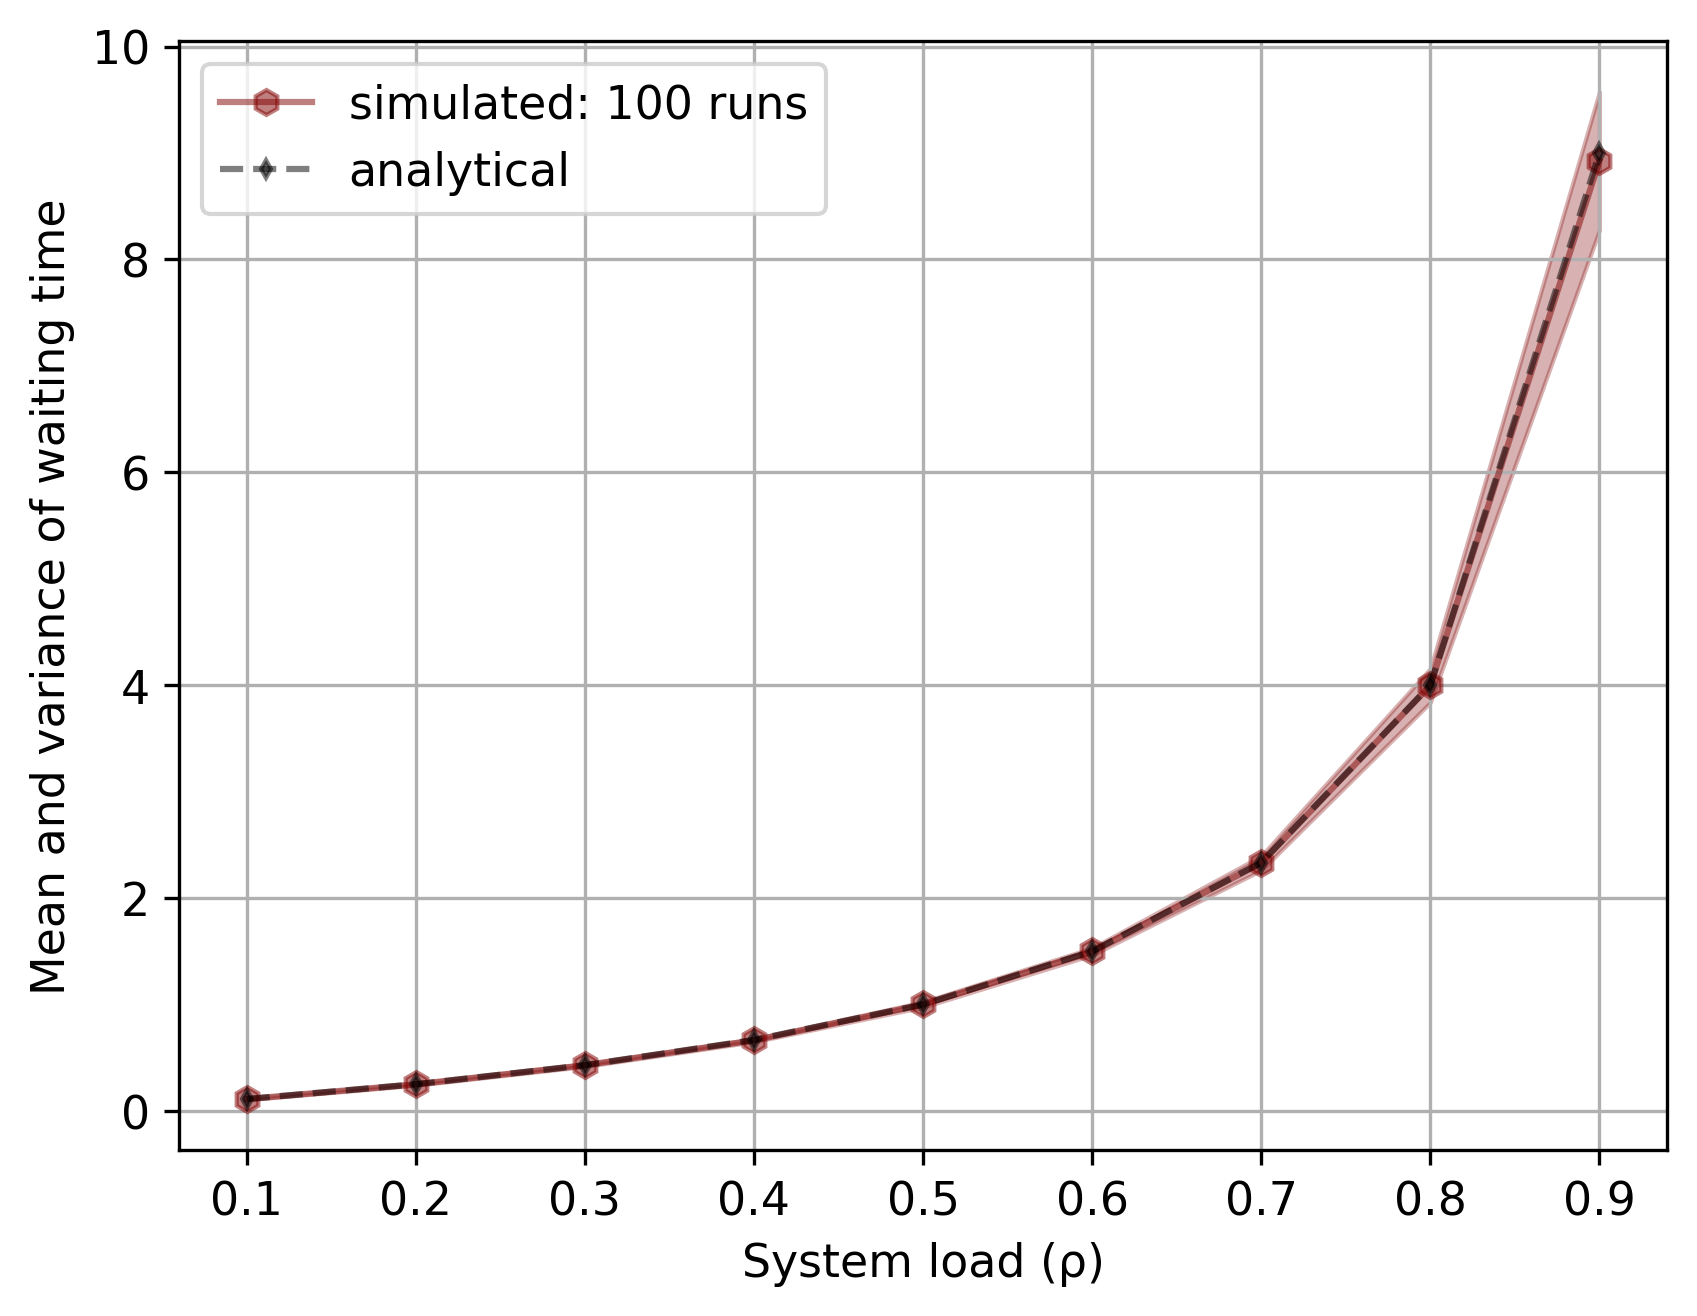

In [5]:
rhos_plotter(filename, "different_rhos_refactor.png")

In [6]:
def compute_difference(values):
    """
    Returns difference the last element of the array
    and the individual elements of the array.
    """
    
    i = [c for c in values]
    max_value = i[-1]

    return np.abs(i - max_value)

In [7]:
"""
Saving data for histograms and bar plots: M/M/1, M/M/2, M/M/4.
"""
random.seed(0x101ca7)
SIM_TIME = 2*10**4
server_counts = np.array([1,2,4])

number_of_runs = 1000

ρ = 0.9
μ = 1.0
λ_values = [μ*ρ*n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = exp_factory(μ)

filename = "waiting_times_fullsave_124.dat"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/M/{n}===")
        for run in range(number_of_runs):
            if run % 5 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting) #waiting time, not sojourn
    
    with open(filepath, "wb") as f:
        pickle.dump(waiting_times, f, pickle.HIGHEST_PROTOCOL)
    
else:
    with open(filepath, "rb") as f:
        waiting_times = pickle.load(f)
        

assert len(waiting_times) == len(server_counts)

for wtimes in waiting_times:
    assert len(wtimes) == number_of_runs

In [8]:
def markovian_histogram(simulation_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot`
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    with open(filepath, "rb") as f:
        data = pickle.load(f)
        
    df = pd.DataFrame((data), index=["1", "2", "4"])
    
    df_t = df.T
    
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': False})
    
#     sns.axes_style("whitegrid")
    
    fig = sns.displot(df_t, bins = 60, kde = True, legend = False, palette=palette) #husl"CMRmap_r"
    
    plt.xlabel("Mean waiting time")
    
    plt.legend(loc = 1, title = "Number of servers (n)", labels= ["4", "2", "1"])
    title = plot_savepath(title)
    plt.savefig(title)
    
    plt.show()


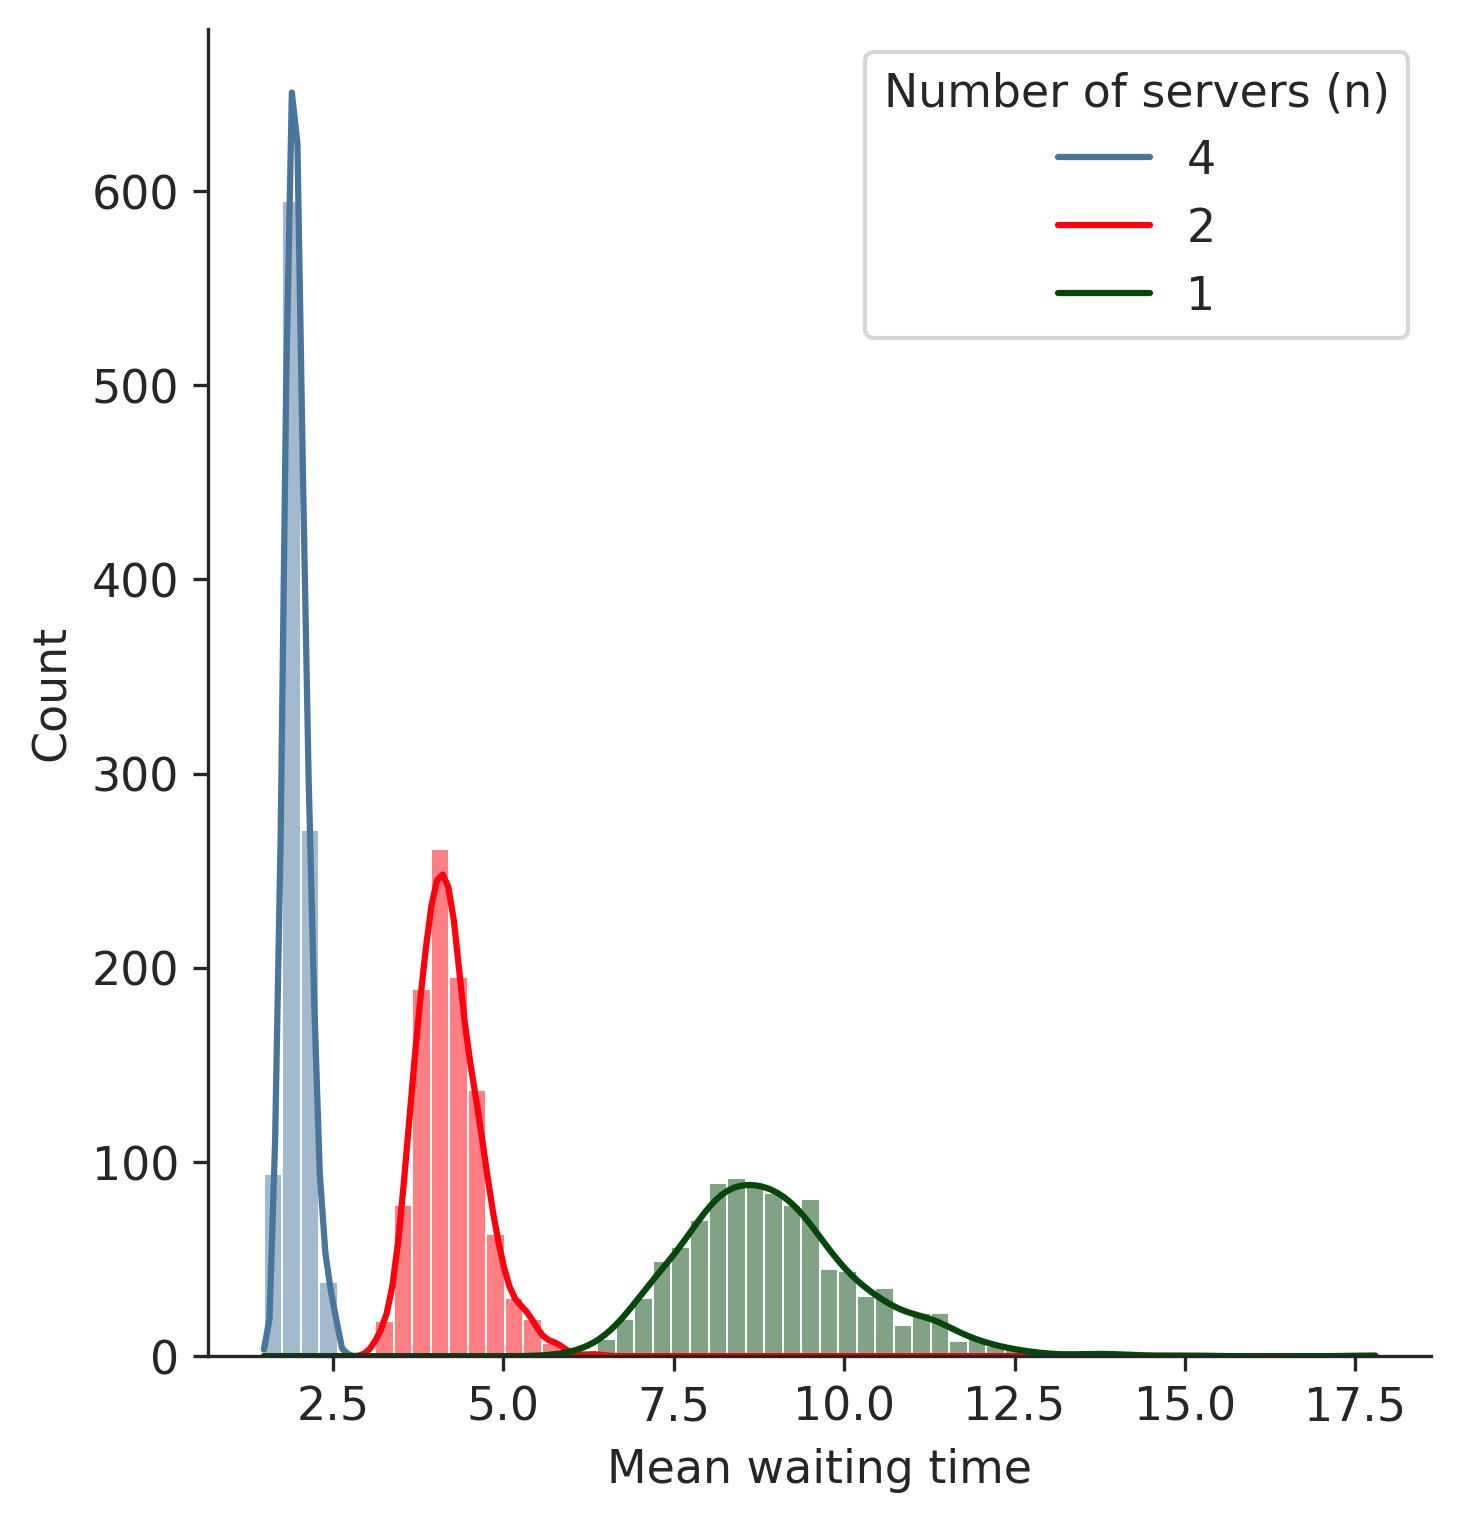

In [9]:
markovian_histogram(simulation_data = "waiting_times_fullsave_124.dat", title = "Markovian_histogram.png")

In [10]:
def dashed_heading(text, length):
    """Pretty printing headings flanked by dashes."""
    dash_length = max(length - len(text), 0)
    ldash_length = dash_length // 2
    rdash_length = dash_length - ldash_length
    ldash = "-" * ldash_length
    rdash = "-" * rdash_length
    return ldash + text + rdash

In [11]:
def welch_ttest(x, y): 
    
    # TODO: change for one-tailed
    """
    Parameteric two-sample Welch test for comparing the expectation values of two
    distributions when their second cumulants are not known.
    
    Prints the results of the test.
    """
    ## Welch-Satterthwaite Degrees of Freedom ##
    
    x_size = len(x)
    x_smean = np.mean(x)
    x_svar = np.sum(np.power(x - x_smean, 2)) / (x_size-1)
    
    y_size = len(y)
    y_smean = np.mean(y)
    y_svar = np.sum(np.power(y - y_smean, 2)) / (y_size-1)
    
    
    dof = (x_svar/x_size + y_svar/y_size)**2 / ((x_svar/x_size)**2 / (x_size-1) + (y_svar/x_size**2 / (x_size-1)))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print( 
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}", 
          dashed_heading("", 80))

In [12]:
def markovian_boxplot(simulation_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot
    
    Return t-test results
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    with open(filepath, "rb") as f:
        data = pickle.load(f)
        
    print("Pair-wise Welch-test:")
    print("M/M/1 and M/M/2:")
    welch_ttest(data[0], data[1])
    
    print("M/M/1 and M/M/4:")
    welch_ttest(data[0], data[2])
    
    print("M/M/2 and M/M/4:")
    welch_ttest(data[1], data[2])
        
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])
    
    df = pd.DataFrame(np.transpose(data), columns = ["1", "2", "4"])
    
    plt.figure(figsize=(4,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.8, 
                 fliersize=2, width = 0.6, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Number of servers (n)")
    plt.ylabel("Mean waiting time")
    title = plot_savepath(title)
    plt.savefig(title)
    plt.show()


Pair-wise Welch-test:
M/M/1 and M/M/2:
Welch's t-test= 107.0018 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1182.6543 --------------------------------------------------------------------------------
M/M/1 and M/M/4:
Welch's t-test= 165.9660 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1023.9875 --------------------------------------------------------------------------------
M/M/2 and M/M/4:
Welch's t-test= 141.5116 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 796.6587 --------------------------------------------------------------------------------


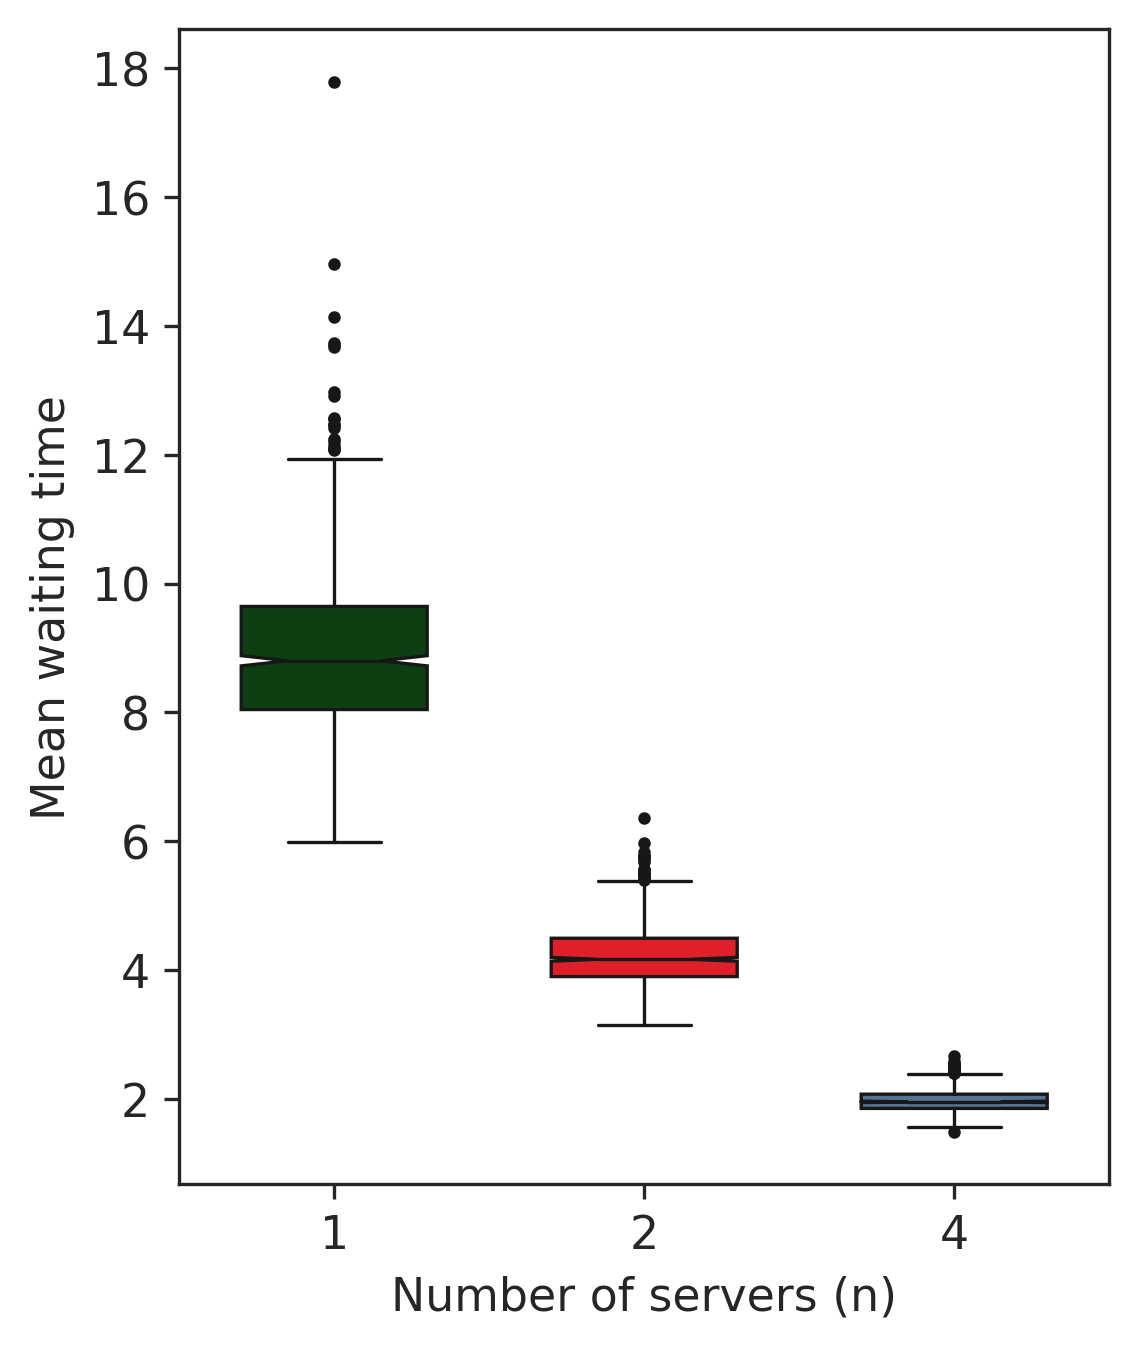

In [13]:
markovian_boxplot(simulation_data = "waiting_times_fullsave_124.dat", title = "Markovian_boxplot.png")

In [14]:
simulation_times = np.logspace(2, 6, num = 5, base = 10)
# server_counts = np.array([1,2,4])
μ = 1.0
ρ_values = np.linspace(0, 1, 11)[5:-1]
number_of_runs = 20

service_t_dist = exp_factory(μ)

# n1 = len(server_counts)
n2 = len(ρ_values)
n3 = len(simulation_times)

mean_waiting_times = np.zeros((n2, n3))
svar_waiting_times = np.zeros((n2, n3))

print(ρ_values)

filename = "transient_to_SS.npz"
filepath = savepath(filename)


if not exists(filepath):
    for j, ρ in enumerate(ρ_values):
        print(f"ρ = {ρ}")
        λ = μ * ρ
        interarrival_t_dist = exp_factory(λ)
        for k, T in enumerate(simulation_times):
            print(f"Simulation time = {T}")
            batch_means = np.zeros(number_of_runs)
            for l in range(number_of_runs):
                env = simpy.Environment()
                system = System(env, 1, service_t_dist)
                system.env.process(sim_setup(system, interarrival_t_dist))
                system.env.run(until = T)
                batch_means[l] = np.mean(system.ts_waiting)
            smean, svar = sample_mean_variance(batch_means)
            mean_waiting_times[j][k] = smean
            svar_waiting_times[j][k] = svar
    np.savez(filepath, mean_waiting_times, svar_waiting_times)
else:
    save_data = np.load(filepath)
    mean_waiting_times = save_data['arr_0']
    svar_waiting_times = save_data['arr_1']

[0.5 0.6 0.7 0.8 0.9]


In [15]:
def compute_difference(values):
    """
    Returns difference the last element of the array
    and the individual elements of the array.
    """
    
    i = [c for c in values]
    max_value = i[-1]

    return np.abs(i - max_value)

In [16]:
def varying_sim_time_plotter(simulation_data, title, rho):

    """

    """

    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)
    
    mean_waiting_times = data['arr_0']
    svar_waiting_times = data['arr_1']

    
    if rho == 0.5:
        mean = mean_waiting_times[0]
        svar = svar_waiting_times[0]

    elif rho == 0.6:
        mean = mean_waiting_times[1]
        svar = svar_waiting_times[1]

    elif rho == 0.7:
        mean = mean_waiting_times[2]
        svar = svar_waiting_times[2]
        
    elif rho == 0.8:
        mean = mean_waiting_times[3]
        svar = svar_waiting_times[3]
    
    elif rho == 0.9:
        mean = mean_waiting_times[4]
        svar = svar_waiting_times[4]
    
    
    simulation_times = np.logspace(2, 6, num = 5, base = 10)
    std = np.sqrt(svar) 

    n = 20 # number of runs
    
    conf_95 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(svar)/np.sqrt(n)
   
    difference = compute_difference(values = conf_95)

    ax = plt.gca() 

    plt.plot(simulation_times, mean, alpha = 0.5, color = "darkred", marker = "h", label = "$ρ = $" + str(rho))
    plt.fill_between(simulation_times, mean - conf_95, mean + conf_95, alpha = 0.3, color = "darkred")
    
    plt.xlabel("Simulation time")
    plt.xscale('log')
    ax.set_ylim(0.06, 12.7)
    plt.legend()
    ax.set_ylabel(r"Mean waiting time $\langle \overline{T}_q \rangle$", color = "darkred")
    plt.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(simulation_times, difference, color = 'black', marker = "D", markersize = 4, linestyle = "-.", alpha = 0.7)
    for xitem, yitem in np.nditer([simulation_times, difference]):
        etiqueta = "{:.3f}".format(yitem)
        plt.annotate(etiqueta, (xitem, yitem), size = 11, color = "black", textcoords="offset points",xytext=(0,10),ha="center")
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(-0.4, 3.7)
    ax2.set_ylabel("Absolute difference in 95% CI", color = 'black')
    
    title = plot_savepath(title)
    plt.savefig(title)
    plt.show()

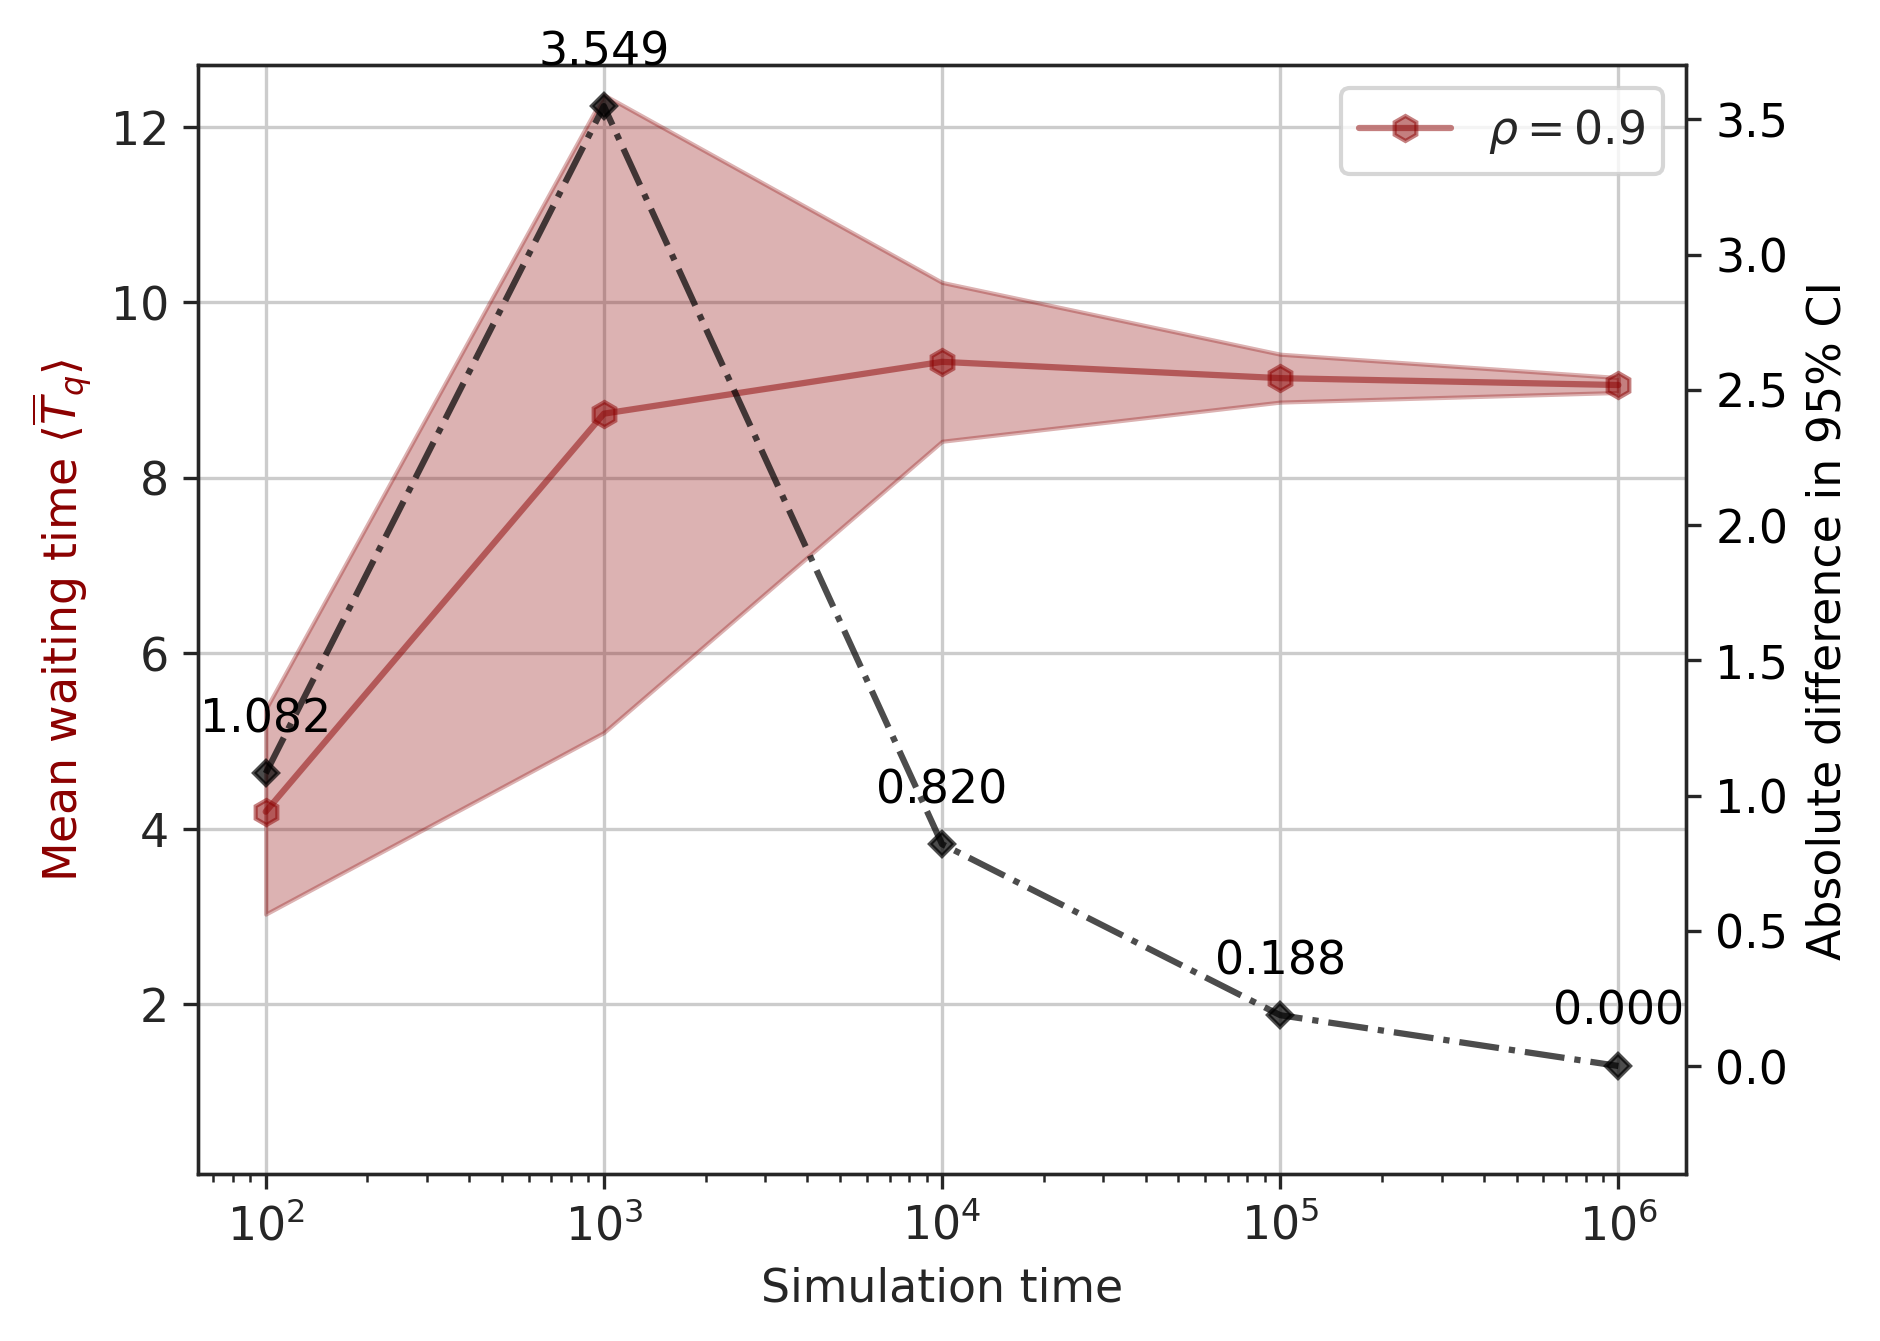

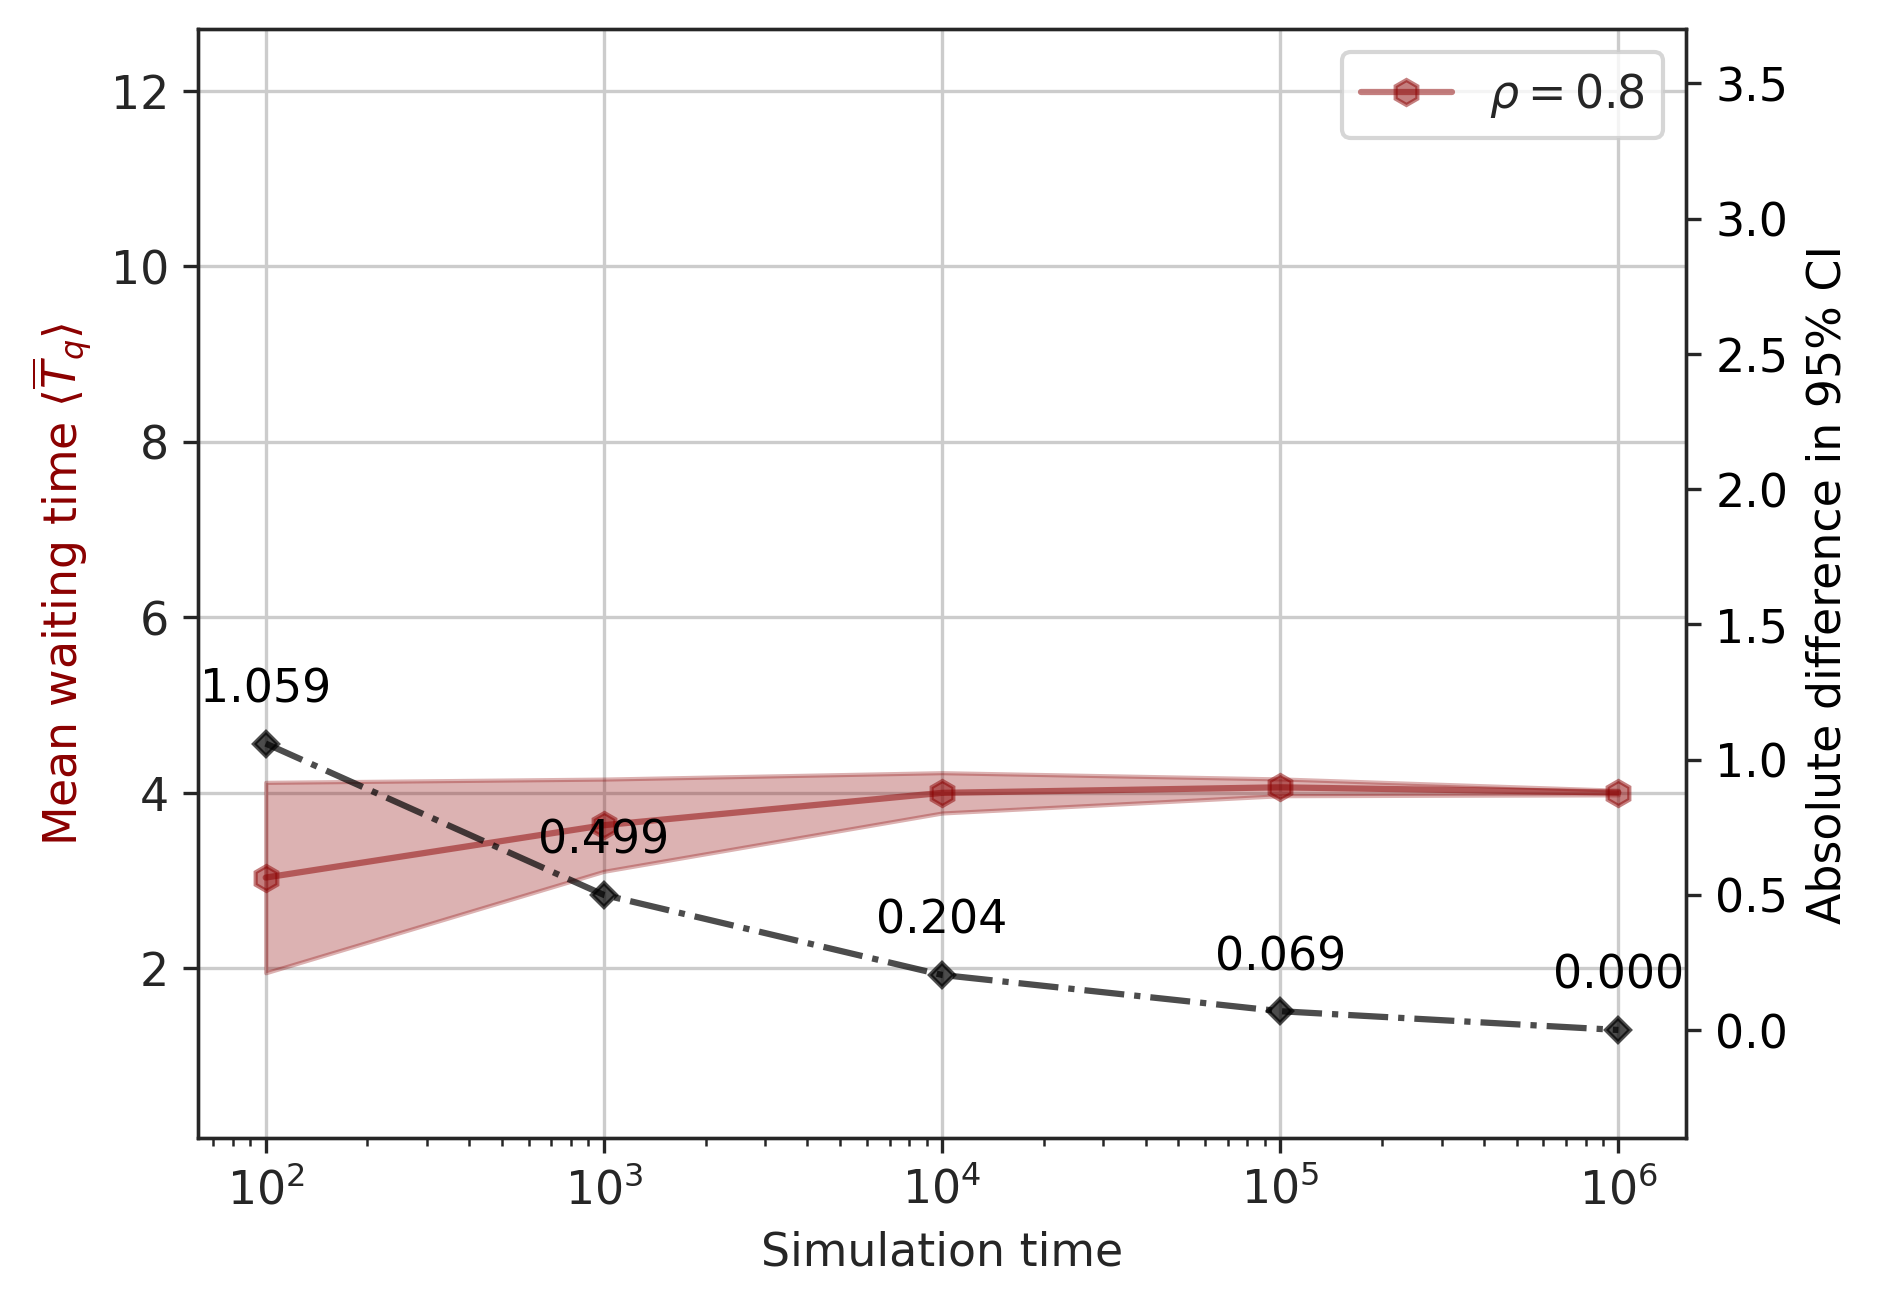

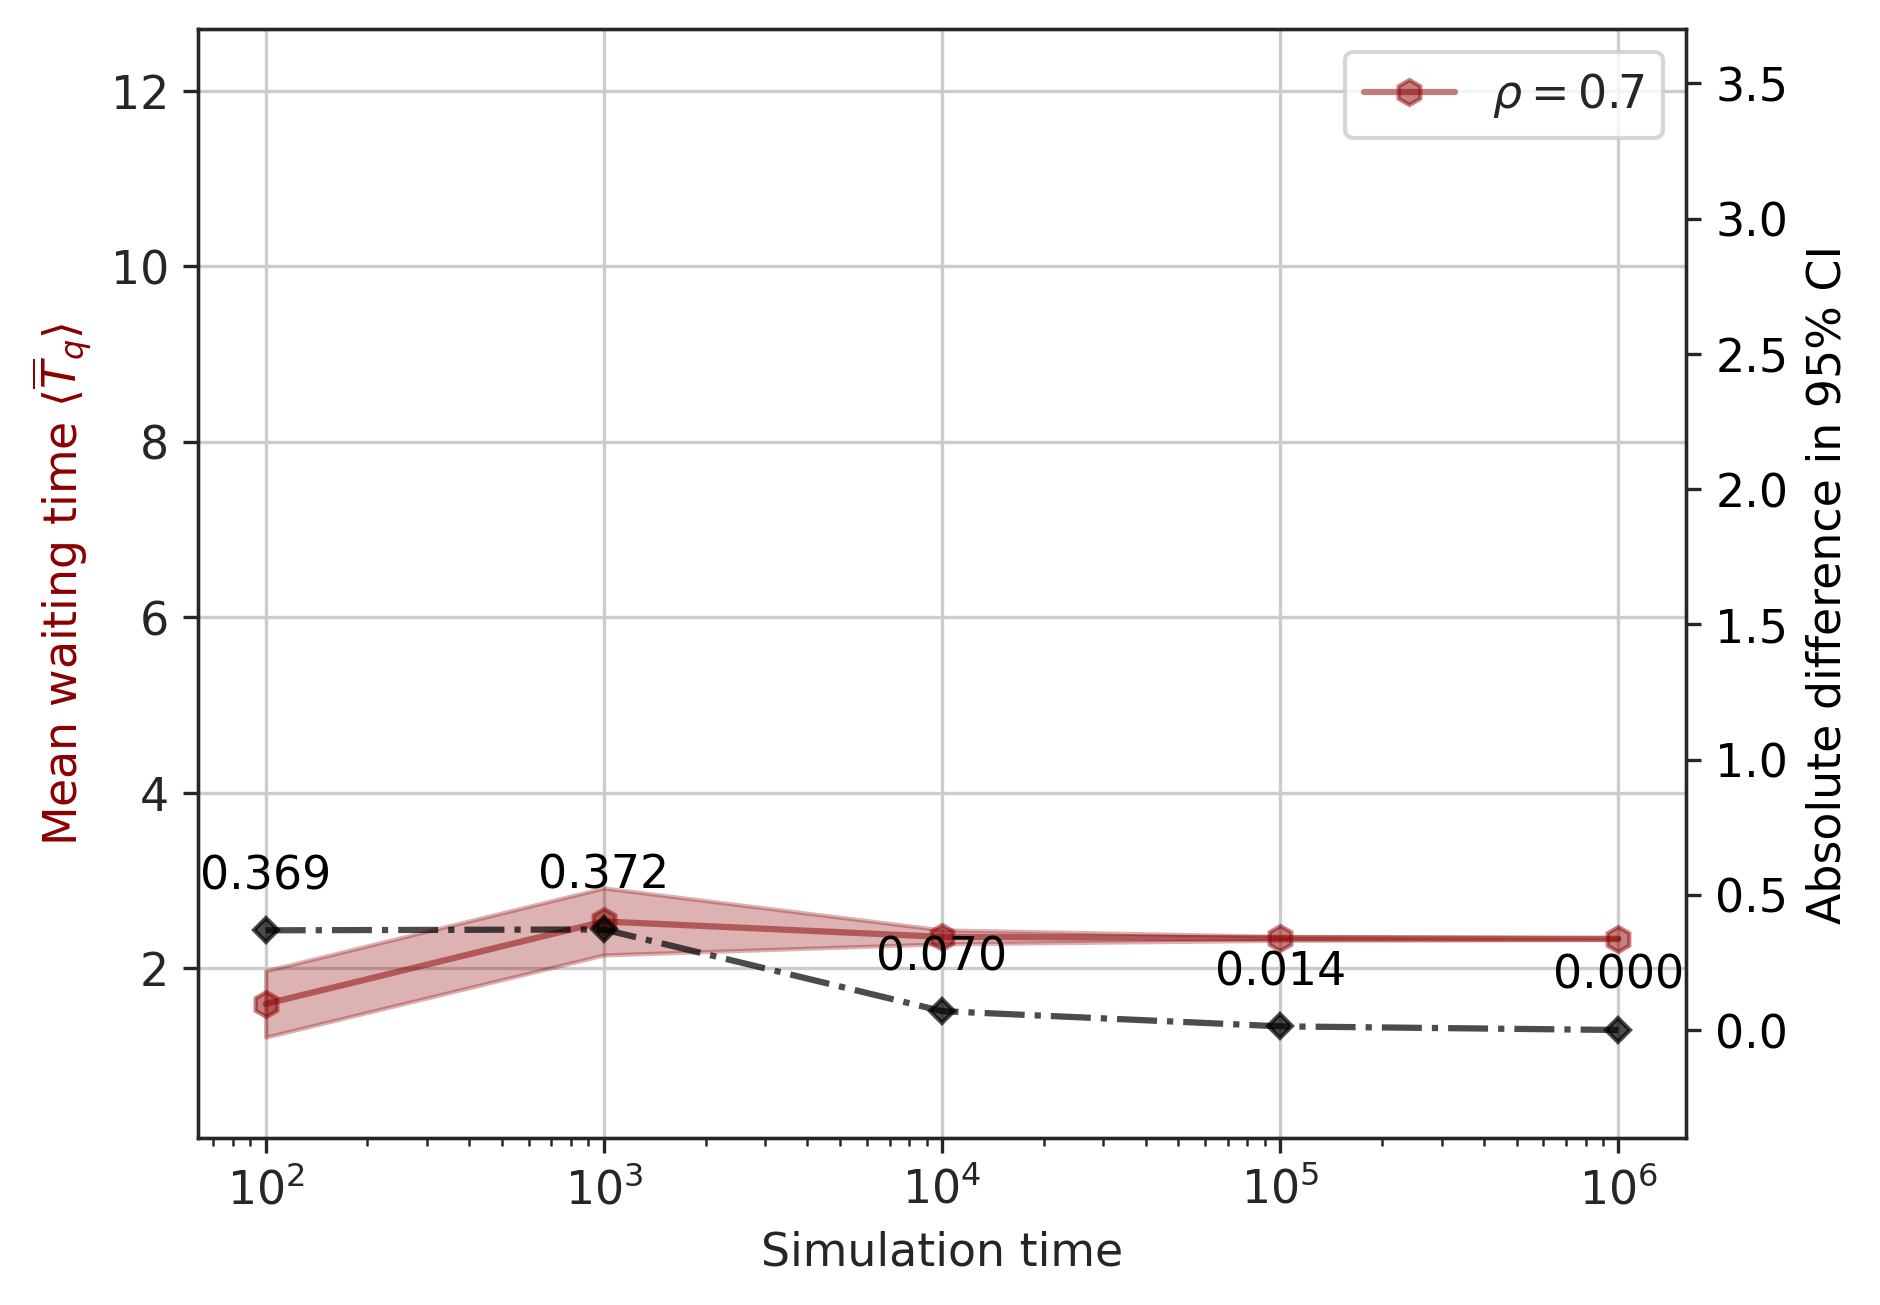

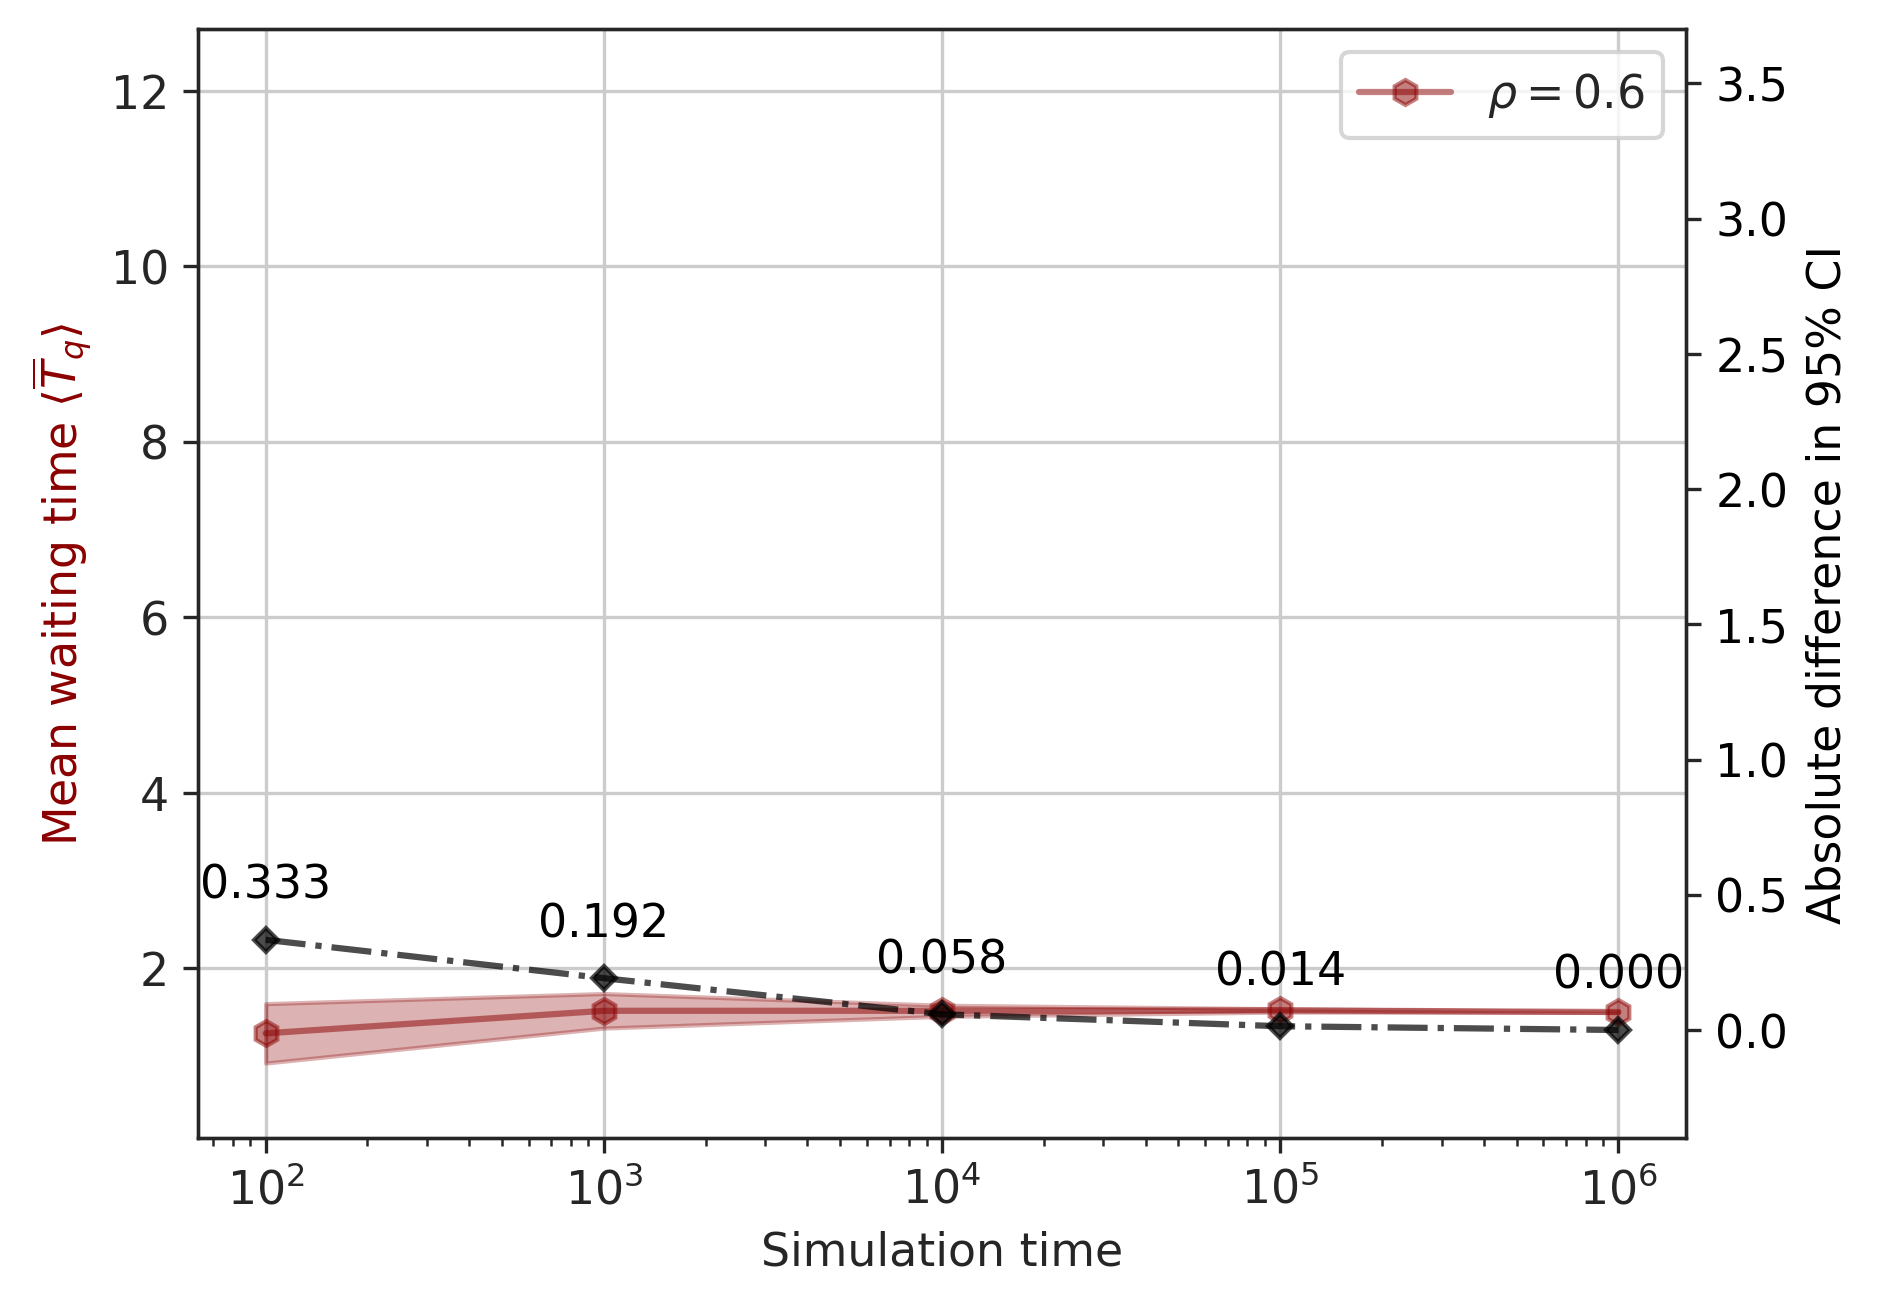

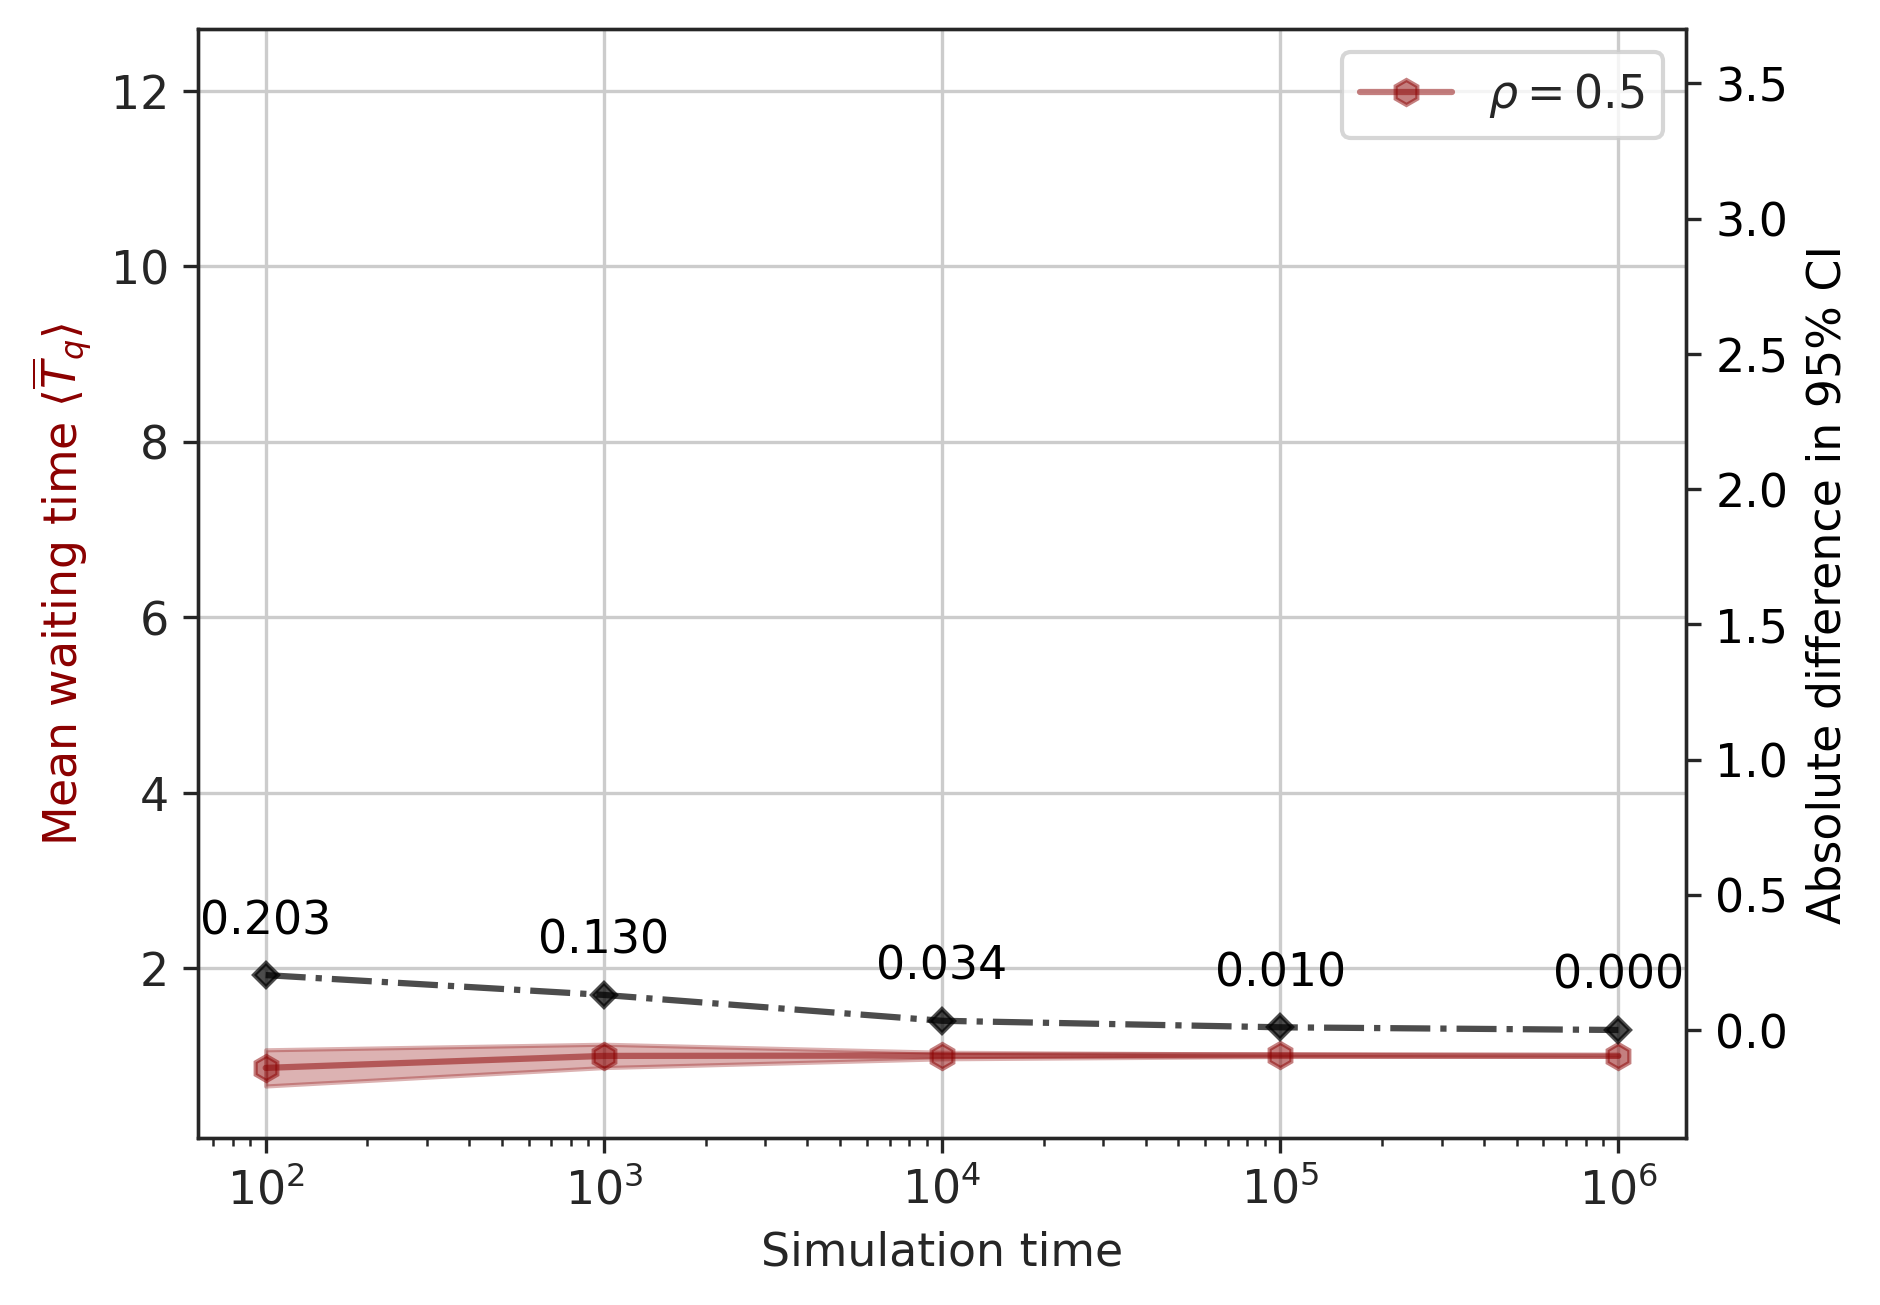

In [17]:
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_09.png", rho = 0.9)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_08.png", rho = 0.8)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_07.png", rho = 0.7)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_06.png", rho = 0.6)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_05.png", rho = 0.5)